In [1]:
import importlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
import random
import time
import collections
import os
import sys
import pandas as pd
import json

matplotlib.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
from matplotlib.pyplot import cm

In [5]:
from at_aloha import AT
from aloha_q import ALOHA_Q
from eb_aloha import EB_ALOHA
from aloha_qtf import QTF
import experiments as exp

### Run protocols and save the result as a json file

In [3]:
def run_ramp(protocol, n_runs=20, delayed=False, detect_energy=True, **kwargs):
    runs = []
    for run_idx in range(n_runs):
        r = exp.ramp(protocol, 
                     seed=run_idx, 
                     delayAck=delayed, 
                     detect_energy=detect_energy, **kwargs)
        runs.append(r)
        print(".", end="")
    return runs


def run_churn(protocol, n_runs=20, num_players=20,
              delayed=False, detect_energy=True, **kwargs):
    t0 = time.time()
    runs = []
    for run_idx in range(n_runs):
        r = exp.churn(protocol,
                      num_players=num_players,
                      seed=run_idx, 
                      delayAck=delayed, 
                      detect_energy=detect_energy, **kwargs)
        runs.append(r)
        print(".", end="")
    return runs

In [10]:
def at(**kwargs):
    return AT(**kwargs)

def eb(**kwargs):
    return EB_ALOHA(**kwargs)

def q(**kwargs):
    return ALOHA_Q(**kwargs)

def qtf(**kwargs):
    return QTF(**kwargs)

# runs_at = run_ramp(at, n_runs=20)
# runs_eb = run_ramp(eb, n_runs=20)
# runs_q = run_ramp(q, n_runs=20)

In [11]:
runs_qtf = run_ramp(qtf, n_runs=20)

....................

In [12]:
exp.save_runs(runs_at, "ramp_at.json")
exp.save_runs(runs_qtf, "ramp_qtf.json")
exp.save_runs(runs_eb, "ramp_eb.json")
exp.save_runs(runs_q, "ramp_q.json")

### Read result from json and plot result

In [14]:
runs_at = exp.read_runs("ramp_at.json")
runs_qtf = exp.read_runs("ramp_qtf.json")
runs_eb = exp.read_runs("ramp_eb.json")
runs_q = exp.read_runs("ramp_q.json")

In [15]:
def plot_utilizations_w_err(utils, names=None, vertsize=2.,
                            title=None, loc=None,
                            xlabel="Time blocks (1 block = 100 time slots)", 
                            fn=None, ramp=True, 
                            colors=['blue', 'red', 'green', 'brown', 'grey'],
                           ):
    matplotlib.rcParams['figure.figsize'] = (5.0, vertsize)
    extra = {
        'e1': (4, 2, 1, 2, 1, 2)
    }
    ls = ['-', '--', ':', '-.', 'e1']
    fig, ax = plt.subplots()
    for i, u in enumerate(utils):
        y = np.vstack([r.total_utilization for r in u])
        mean = np.average(y, axis=0)
        std = np.std(y, axis=0, ddof=1)
        er_pos = np.minimum(mean + std, 1.)
        er_neg = np.maximum(mean - std, 0.)
        x = np.arange(len(mean))
        if ls[i] in extra:
            ax.plot(mean, color=colors[i], dashes=extra[ls[i]], label=names[i] if names else None)
        else:
            ax.plot(mean, color=colors[i], ls=ls[i], label=names[i] if names else None)
        ax.fill_between(x, er_pos, er_neg, facecolor=colors[i], alpha=0.2)

    plt.ylim((-0.05, 1.05))
    plt.yticks(np.arange(0., 1.25, 0.25))
    plt.ylabel("Network utilization")
    
    if ramp:
        x_position = np.array([t for i, t in enumerate(x) if i%50 ==0])
        plt.xlim(-1, 301)
    else:    
        x_position = np.array([t for i, t in enumerate(x) if i%50 ==0])
        plt.xlim(-1, 201)

    plt.xticks(x_position, x_position)
    if title:
        plt.title(title)
    if names:
        plt.legend(loc="lower right")
    if xlabel:
        plt.xlabel(xlabel)
    ax.grid()
    if loc:
        plt.legend(loc=loc)
    if fn:
        plt.savefig(fn, bbox_inches='tight')
    plt.show()

In [16]:
def plot_fairness(is_jain, run_sets, names=None, title=None, vertsize=2.,
                  ylabel=None, xlabel="Time blocks (1 block = 100 time slots)", 
                  fn=None, ramp=True, loc=None, 
                  colors=['blue', 'red', 'green', 'brown', 'grey'],
                 ):
    
    matplotlib.rcParams['figure.figsize'] = (5.0, vertsize)
    fig, ax = plt.subplots()
    extra = {
        'e1': (4, 2, 1, 2, 1, 2)
    }    
    ls = ['-', '--', ':', '-.', "e1"]
    
    for i, runs in enumerate(run_sets):
        y = np.vstack([(r.jain if is_jain else r.bottom_fair_ratio) for r in runs]) 
        mean = np.average(y, axis=0)
        std = np.std(y, axis=0, ddof=1)
        er_pos = np.minimum(mean + std, 1.)
        er_neg = np.maximum(mean - std, 0.)
        x = np.arange(len(mean))
        if ls[i] in extra:
            ax.plot(mean, color=colors[i], dashes=extra[ls[i]], label=names[i] if names else None)
        else:
            ax.plot(mean, color=colors[i], ls=ls[i], label=names[i] if names else None)
        
        
        ax.fill_between(x, er_pos, er_neg, facecolor=colors[i], alpha=0.2)
        
    plt.ylim((-0.0, 1.05))
    plt.yticks(np.arange(0., 1.25, 0.25))
    if ramp:
        x_position = np.array([t for i, t in enumerate(x) if i%5 ==0])
        plt.xlim(-0.1, 30)

    else:
        x_position = np.array([t for i, t in enumerate(x) if i%5 ==0])
        plt.xlim(-0.1, 20.1)

    plt.xticks(x_position, x_position*10)
    
    if names:
        plt.legend()
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    ax.grid()
    if loc:
        plt.legend(loc=loc)
    if fn:
        plt.savefig(fn, bbox_inches='tight')
    plt.show()

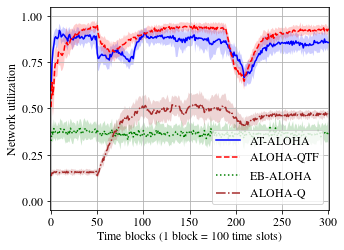

In [20]:
plot_utilizations_w_err([runs_at, runs_qtf, runs_eb, runs_q], vertsize=3.75,
                        names=["AT-ALOHA", "ALOHA-QTF", "EB-ALOHA", "ALOHA-Q"])

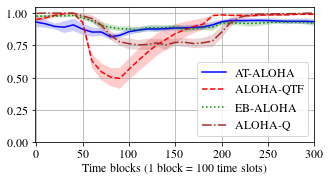

In [25]:
plot_fairness(True, [runs_at, runs_qtf, runs_eb, runs_q], vertsize=2.5,
                names=["AT-ALOHA", "ALOHA-QTF", "EB-ALOHA", "ALOHA-Q"])

#### Plot success, collision and empty rate of one protocol

In [47]:
def plot_protocol(runs, title, vertsize=2, xlabel=None, fn=None):
    matplotlib.rcParams['figure.figsize'] = (5.0, vertsize)
    colors = {"success": 'black', "collision": 'red', "empty": 'green'}
    ls = {"success": '-', "collision": '--', "empty": '-.'}
    
    result = {"success": np.array([i.total_utilization for i in runs]),
              "collision": np.array([i.collisions for i in runs]),
              "empty": np.array([i.empty for i in runs]),
             }
    fig, ax = plt.subplots(dpi=80)
    for name, y in result.items():
        mean = np.average(y, axis=0)     
        std = np.std(y, axis=0, ddof=1)
        er_pos = np.minimum(mean + std, 1.)
        er_neg = np.maximum(mean - std, 0.)
        x = np.arange(len(mean))
        ax.plot(mean, color=colors[name], ls=ls[name], label=name)
        ax.fill_between(x, er_pos, er_neg, facecolor=colors[name], alpha=0.2)
    plt.ylim((-0.05, 1.05))
    plt.xlim(-1, len(mean))
    plt.yticks(np.arange(0., 1.25, 0.25))
    plt.ylabel("Network utilization")
    plt.title(title)
    plt.legend(loc="best")
    ax.grid()
    if xlabel:
        plt.xlabel(xlabel)
    if fn:
        plt.savefig(fn.format(node), bbox_inches='tight')
    plt.show()

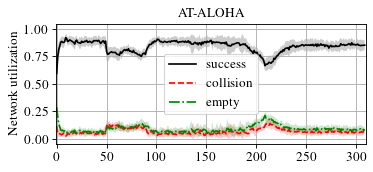

In [48]:
plot_protocol(runs_at, "AT-ALOHA")

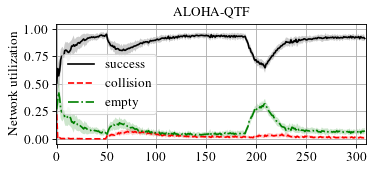

In [49]:
plot_protocol(runs_qtf, "ALOHA-QTF")

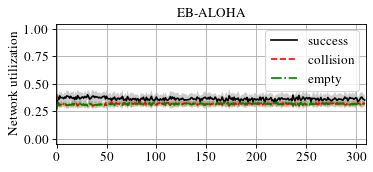

In [50]:
plot_protocol(runs_eb, "EB-ALOHA")

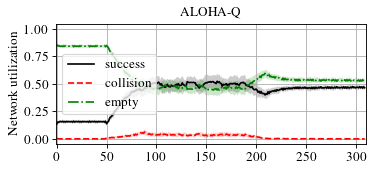

In [51]:
plot_protocol(runs_q, "ALOHA-Q")